## Setup

In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral


# load dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

model = None
modelName = 'model_conv2D'

greyscale = True
augmentation = False

# Number of augmentations per image
num_augmentations = 0

2024-07-29 17:48:31.145254: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 17:48:31.169146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 17:48:31.810495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-29 17:48:32.626725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 17:48:32.673236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 17:48:32.673267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/Training_3908.jpg')
print(f'\nImage size: {img.shape}')

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
input_shape = (48, 48, 1)

Number of training images in each class:
angry: 6073 images
disgust: 659 images
fear: 6178 images
happy: 11045 images
neutral: 7589 images
sad: 7353 images
surprise: 4583 images

Number of test images in each class:
angry: 1459 images
disgust: 156 images
fear: 1527 images
happy: 2694 images
neutral: 1901 images
sad: 1889 images
surprise: 1134 images

Image size: (48, 48, 3)


## Preparing different models

In [3]:
# CNN MODEL
input_layer = tf.keras.layers.Input(shape=input_shape)

# Erster konventioneller Convolutional Pfad
conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(input_layer)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.ReLU()(conv1)
conv1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
dropout1 = tf.keras.layers.Dropout(0.2)(conv1)

# Zweiter konventioneller Convolutional Pfad
conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(dropout1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.ReLU()(conv2)
conv2 = tf.keras.layers.MaxPooling2D(2, 2)(conv2)
dropout2 = tf.keras.layers.Dropout(0.2)(conv2)

# Dritter konventioneller Convolutional Pfad
conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(dropout2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv3)
conv3 = tf.keras.layers.MaxPooling2D(2, 2)(conv3)
dropout3 = tf.keras.layers.Dropout(0.2)(conv3)

# Vierter konventioneller Convolutional Pfad
conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(dropout3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
conv4 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv4)
conv4 = tf.keras.layers.MaxPooling2D(2, 2)(conv4)
dropout4 = tf.keras.layers.Dropout(0.2)(conv4)

# Fünfter konventioneller Convolutional Pfad
conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(dropout4)
conv5 = tf.keras.layers.BatchNormalization()(conv5)
conv5 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv5)
conv5 = tf.keras.layers.MaxPooling2D(2, 2)(conv5)
dropout5 = tf.keras.layers.Dropout(0.2)(conv5)

# Paralleler Pfad mit Dilated Convolutions
# dilated1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', dilation_rate=3)(input_layer)
# dilated1 = tf.keras.layers.BatchNormalization()(dilated1)
# dilated1 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated1)
# dilated1 = tf.keras.layers.MaxPooling2D(2, 2)(dilated1)
# dropout1dilated = tf.keras.layers.Dropout(0.3)(dilated1)

# dilated2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=3)(dropout1dilated)
# dilated2 = tf.keras.layers.BatchNormalization()(dilated2)
# dilated2 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated2)
# dilated2 = tf.keras.layers.MaxPooling2D(2, 2)(dilated2)
# dropout2dilated = tf.keras.layers.Dropout(0.3)(dilated2)

# dilated3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=4)(dilated2)
# dilated3 = tf.keras.layers.BatchNormalization()(dilated3)
# dilated3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated3)
# dilated3 = tf.keras.layers.MaxPooling2D(2, 2)(dilated3)

# Zusammenführung der Pfade
merged = tf.keras.layers.concatenate([dropout5])

# Flatten und Dense Layers
flat = tf.keras.layers.Flatten()(merged)
dense1 = tf.keras.layers.Dense(512)(flat)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.ReLU()(dense1)
dropout = tf.keras.layers.Dropout(0.3)(dense1)
output = tf.keras.layers.Dense(7, activation='softmax')(dropout)

# Modell definieren
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2024-07-29 16:34:56.872765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 16:34:56.872816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 16:34:56.872831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 16:34:56.951972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 16:34:56.952008: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 256)      │         1,02

 Total params: 531,527 (2.03 MB)

 Trainable params: 529,511 (2.02 MB)

 Non-trainable params: 2,016 (7.88 KB)

## Loading the images from disk

In [4]:
def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
    return img

# Load the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

# Normalize the images to [0,1]
train_ds = train_ds.map(lambda img, label: (normalize_image(img), label))
test_ds = test_ds.map(lambda img, label: (normalize_image(img), label))

# One-Hot-Encoding of the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

num_classes = 7

train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

Found 43479 files belonging to 7 classes.
Found 10764 files belonging to 7 classes.


In [5]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_contrast(img, lower=0.6, upper=1.4)
    # Some augmentations are only applicable to RGB images
    if not greyscale:
        img = tf.image.random_hue(img, max_delta=0.2)
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    return img, label

def augment_multiple(img, label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    for _ in range(num_augmentations):
        augmented_img, augmented_label = augment(img, label)
        augmented_images.append(augmented_img)
        augmented_labels.append(augmented_label)
    return tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Augment the training data
if augmentation:
    augmented_datasets = train_ds.flat_map(lambda img, label: augment_multiple(img, label, num_augmentations))
    train_ds = train_ds.concatenate(augmented_datasets)

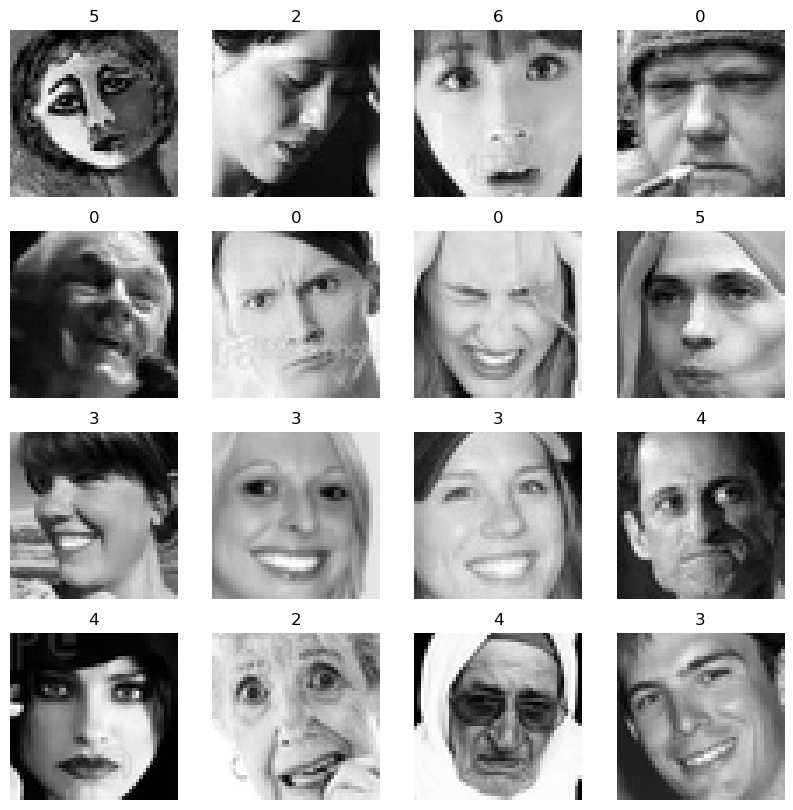

2024-07-29 16:35:22.734138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()


Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


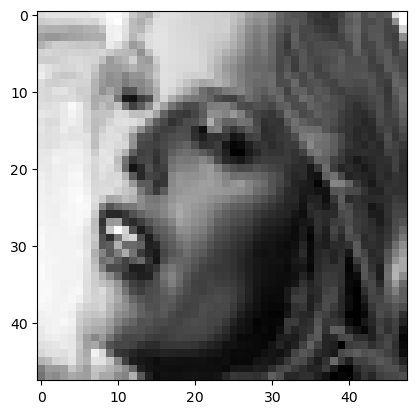

2024-07-29 16:35:22.806176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")
    
    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap='gray')
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

In [8]:
import collections

def get_class_distribution(dataset):
    class_counts = collections.Counter()
    
    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())
    
    return class_counts

# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


2024-07-29 16:35:30.692766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 11045, 4: 7589, 5: 7353, 2: 6177, 0: 6073, 6: 4583, 1: 659})
Test Class Distribution: Counter({3: 2694, 4: 1903, 5: 1889, 2: 1527, 0: 1461, 6: 1134, 1: 156})


2024-07-29 16:35:32.708230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import sklearn
from sklearn.utils import class_weight

# Load test data
x_train = []
y_train = []

for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        # img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            # img = cv2.resize(img, (48, 48))
            # x_train.append(img)
            y_train.append(i)

In [10]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0227941003504974, 1: 9.425536527205724, 2: 1.0054109050548028, 3: 0.56237470089892, 4: 0.8184778721081264, 5: 0.8447475277340638, 6: 1.3553193479006265}
Type of keys: <class 'int'>
Type of values: <class 'float'>


# Custom Callbacks

In [11]:
# Callback function to print the best value of a metric (to roughly predict when the training will finish due to early stopping)
class RecordMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric='val_loss', mode='min'):
        super(RecordMetricCallback, self).__init__()
        self.metric = metric
        self.mode = mode
        self.best_epoch = -1
        self.best_value = None
        if mode == 'min':
            self.best_value = float('inf')
        elif mode == 'max':
            self.best_value = -float('inf')
        else:
            raise ValueError("Mode must be 'min' or 'max'")

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.metric)
        if current_value is not None:
            if (self.mode == 'min' and current_value < self.best_value) or (self.mode == 'max' and current_value > self.best_value):
                self.best_value = current_value
                self.best_epoch = epoch
            print(f'Best {self.metric} so far: {self.best_value:.3f} (Epoch {self.best_epoch + 1})')

# Callbacks

In [12]:
metric = 'val_accuracy'
mode = 'max'

# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor=metric, patience=25, restore_best_weights=True, mode=mode)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=metric, factor=0.2, patience=5, min_lr=1e-7, mode=mode)
record_val_accuracy = RecordMetricCallback(metric=metric, mode=mode)

In [13]:
for image, label in train_ds.take(1):  # Only take the first batch
    print(label[0])  # Show the label

tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)


2024-07-29 16:35:33.088769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training & Evaluation

In [14]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping, record_val_accuracy],
)

Epoch 1/5000


I0000 00:00:1722263734.616629   29394 service.cc:145] XLA service 0x7f1468008aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722263734.616664   29394 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-07-29 16:35:34.661126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-29 16:35:34.860785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 30/680 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1883 - loss: 2.2879

I0000 00:00:1722263739.735109   29394 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1900 - loss: 2.1199Best val_accuracy so far: 0.353 (Epoch 1)
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.1900 - loss: 2.1197 - val_accuracy: 0.3526 - val_loss: 1.6833 - learning_rate: 0.0010
Epoch 2/5000
678/680 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2989 - loss: 1.7746Best val_accuracy so far: 0.417 (Epoch 2)
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2990 - loss: 1.7743 - val_accuracy: 0.4173 - val_loss: 1.4971 - learning_rate: 0.0010
Epoch 3/5000
676/680 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3681 - loss: 1.6087Best val_accuracy so far: 0.430 (Epoch 3)
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3682 - loss: 1.6084 - val_accuracy: 0.4298 - val_loss: 1.4635 - learning_rate: 0.0010
Epoch 4/5000
677/680 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4190 - loss: 1.4821Best val_accuracy so far: 0.493 (Epoch 4)
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4190 - 

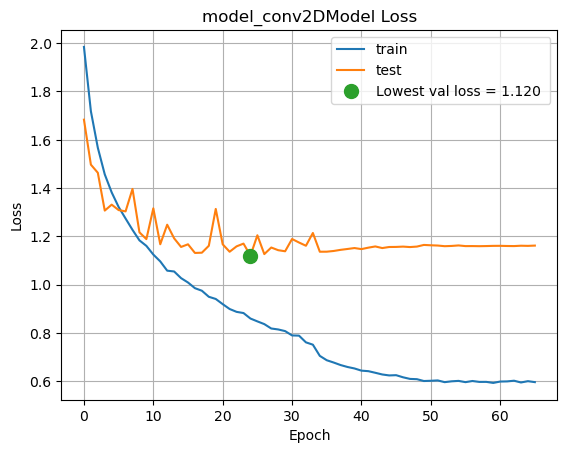

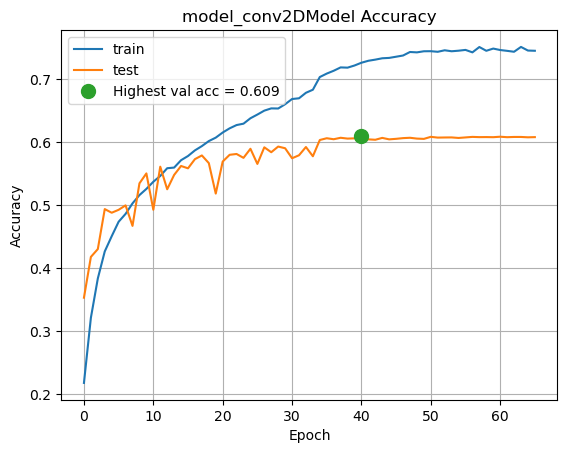

In [15]:
# Plot training history (loss and accuracy)
# Plot the point with the best validation accuracy (early stopping)
# Plot the point with the least validation loss
from textwrap import fill
from turtle import fillcolor, filling


highest_val_acc = np.argmax(history.history['val_accuracy'])
highest_val_acc_item = (highest_val_acc, history.history['val_accuracy'][highest_val_acc])

lowest_val_loss = np.argmin(history.history['val_loss'])
lowest_val_loss_item = (lowest_val_loss, history.history['val_loss'][lowest_val_loss])

plt.plot(history.history['loss'], c="C0", label="train")
plt.plot(history.history['val_loss'], c="C1", label="test")
plt.plot(lowest_val_loss_item[0], lowest_val_loss_item[1], '.', markersize=20, color="C2", label=f"Lowest val loss = {lowest_val_loss_item[1]:.3f} ")
plt.title(modelName + 'Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], c="C0", label="train")
plt.plot(history.history['val_accuracy'], c="C1", label="test")
plt.plot(highest_val_acc_item[0], highest_val_acc_item[1], '.', markersize=20, color="C2", label=f"Highest val acc = {highest_val_acc_item[1]:.3f}")
plt.title(modelName + 'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [3]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


Model saved.
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3006 - loss: 144.8293
[121.43158721923828, 0.3372374176979065]
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15      0.22      1458
           1       0.00      0.00      0.00       156
           2       0.19      0.47      0.27      1527
           3       0.73      0.49      0.59      2694
           4       0.30      0.13      0.18      1900
           5       0.25      0.41      0.31      1889
           6       0.53      0.32      0.40      1134

    accuracy                           0.34     10758
   macro avg       0.34      0.28      0.28     10758
weighted avg       0.41      0.34      0.34     10758

Confusion Matrix:
 [[ 221    0  582   83  110  428   34]
 [  14    0   83   11    2   45    1]
 [  67    0  713   72   92  483  100]
 [ 117    0  689 1322  121  389   56]
 [  59    0  599  106  241  811   

/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

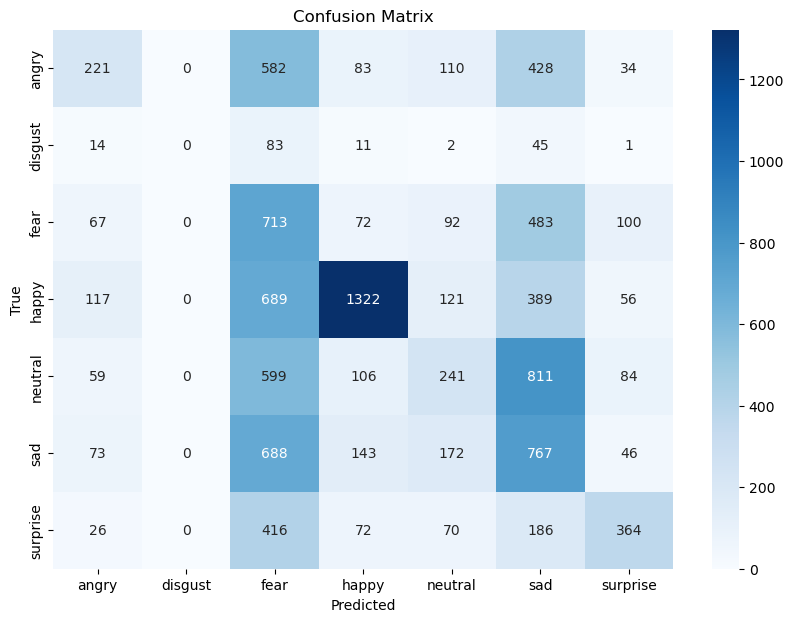

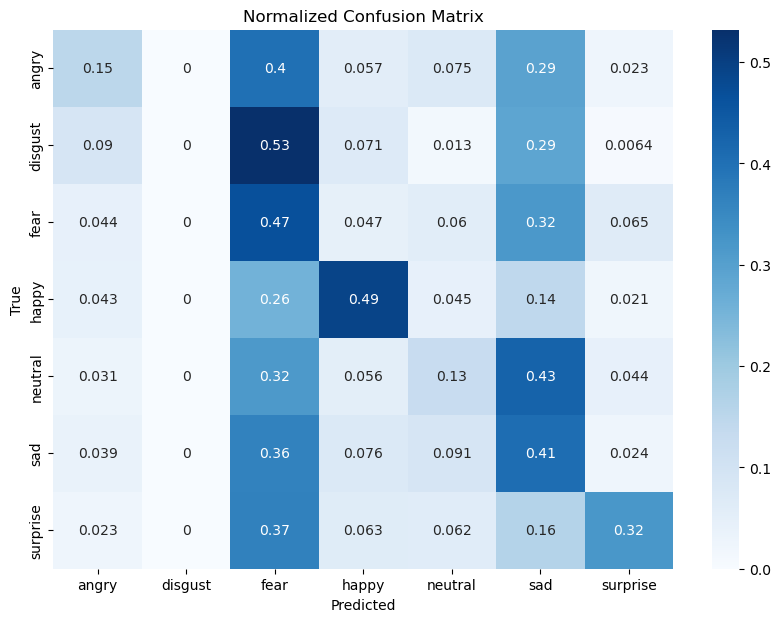

Image shape: (48, 48)


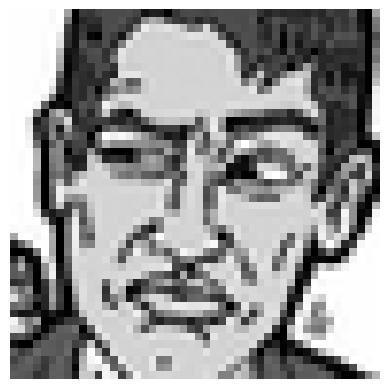

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted emotion: fear


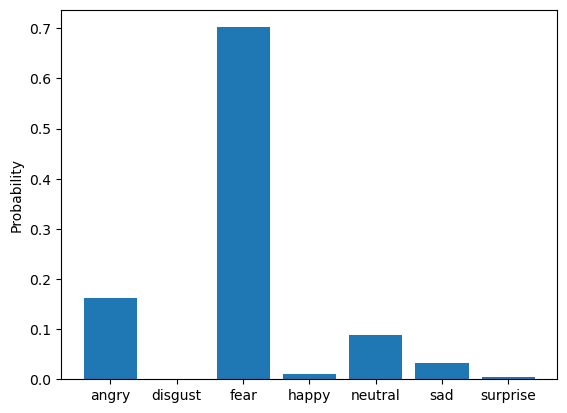

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


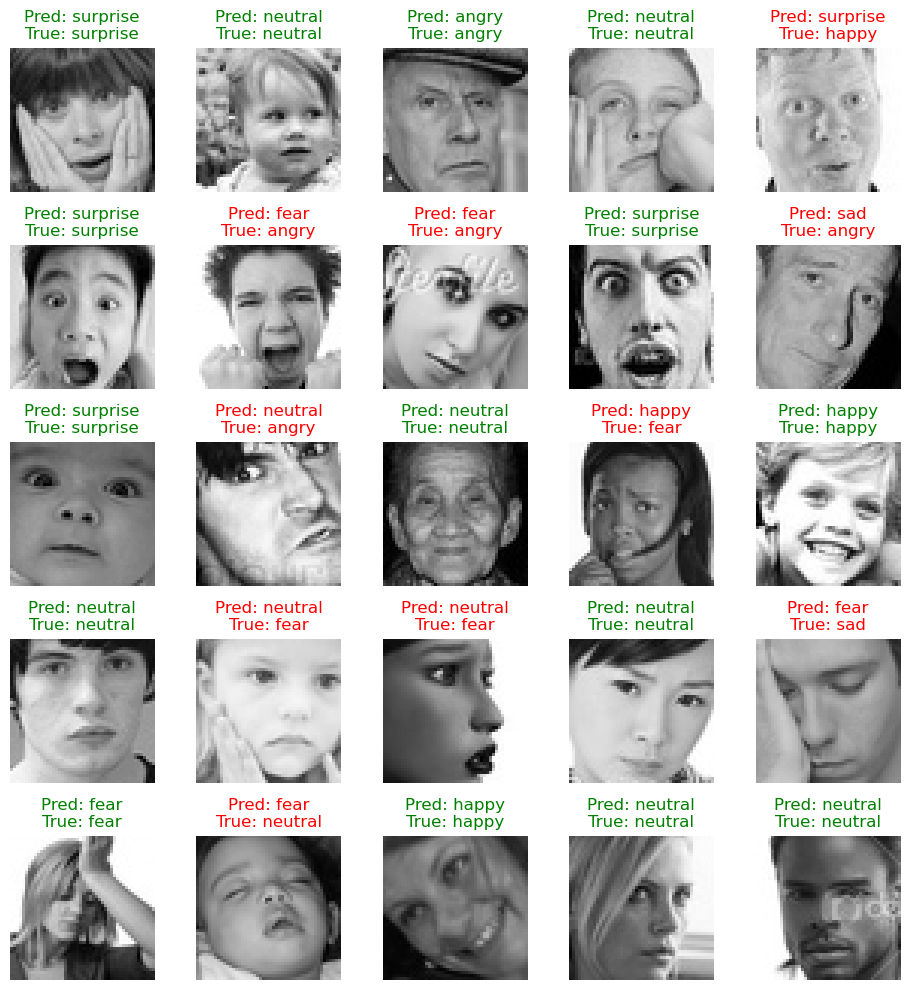

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


IndexError: index 7 is out of bounds for axis 0 with size 7

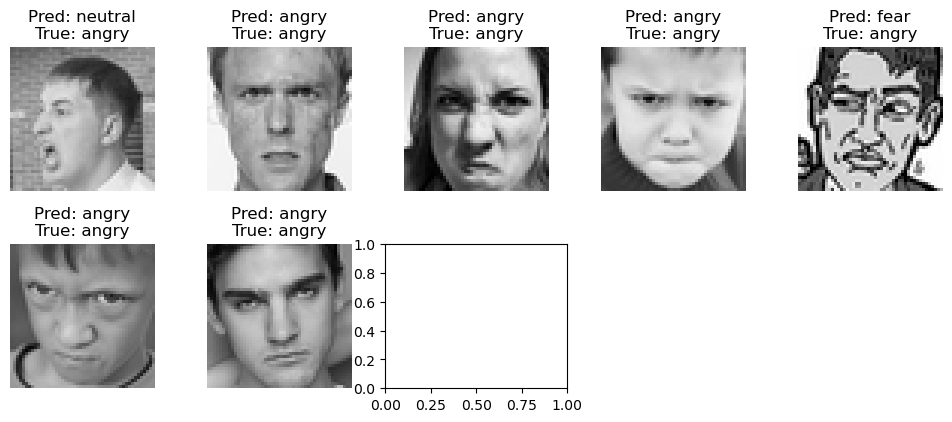

In [7]:
# if history is not None:

#     # PLOT TRAINING AND VALIDATION ACCURACY
#     plt.plot(history.history['accuracy'], label='accuracy')
#     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.show()

#     # PLOT TRAINING AND VALIDATION LOSS
#     plt.plot(history.history['loss'], label='loss')
#     plt.plot(history.history['val_loss'], label = 'val_loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#     plt.show()
    
#     # Zugreifen auf die Metriken im Trainingsverlauf
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     # Beispielausgabe der Genauigkeit
#     print("Training Accuracy:", accuracy)
#     print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined

if model is not None: 
    model.save(modelName + '.keras')
    print('Model saved.')
else:
    # Load model
    model = tf.keras.models.load_model(modelName + '.keras')
    print('Model loaded.')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# Evaluationsergebnisse anzeigen
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=cm_normalized, xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.savefig('normalized_confusion_matrix.png', dpi=300)
plt.show()

# TEST MODEL
# Load test image
file_path = 'dataset/test/angry/PrivateTest_88305.jpg'
img = x_test[0]
print(f'Image shape: {img.shape}')

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

img = np.reshape(img, [1, 48, 48, 1])
img = img / 255.0  # Normalize to [0, 1]
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    img = img / 255.0  # Normalize to [0, 1]
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = 'g' if emotion == true_emotion else 'r'
    plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
    plt.title(f'Pred: {emotion}\nTrue: {true_emotion}', color=color)
    plt.axis('off')
    plt.tight_layout()

plt.savefig('predictions.png', dpi=300)
plt.show()